# Setting and Load library

## import library

In [34]:
############################################################################
# python default library
############################################################################
import os
import glob
import sys
import random
############################################################################
############################################################################
# additional library
############################################################################
# general analysis tool-kit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# sound analysis tool-kit
import librosa
import librosa.core
import librosa.feature

# pytorch
import torch
import torch.utils.data as data
from torch import optim, nn
from torch.utils.data.dataset import Subset

# deeplearning tool-kit
from torchvision import transforms

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
from tqdm import tqdm
############################################################################
# original library
############################################################################
import common as com
from pytorch_model import AutoEncoder

In [2]:
torch.cuda.is_available()

True

## setting seed

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

## setting I/O path 

In [5]:
with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [6]:
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
eval_test_path = INPUT_ROOT + "/eval_test"
# machine type
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

## train/valid split

In [7]:
dev_train_paths = {}
add_train_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_all_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_all_paths = sorted(dev_train_all_paths)
    dev_train_paths[machine_type] = {}
    dev_train_paths[machine_type]['train'], \
    dev_train_paths[machine_type]['valid'] = train_test_split(dev_train_all_paths,
                                                              test_size=config['etc']['test_size'],
                                                              shuffle=False,
                                                             )
    # add_dev train
    add_train_all_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_all_paths = sorted(add_train_all_paths)
    add_train_paths[machine_type] = {}
    add_train_paths[machine_type]['train'], \
    add_train_paths[machine_type]['valid'] = train_test_split(add_train_all_paths,
                                                              test_size=config['etc']['test_size'],
                                                              shuffle=False,
                                                             )

# Data Load and Preprocessing

## Define Preprocessing Class 

In [8]:
class Wav_to_Melspectrogram(object):
    """
    wavデータロード(波形) -> ログメルスペクトログラム
    
    Attributes
    ----------
    dims = n_mels * frames
    sound_data : numpy.ndarray.shape = (timecourse, dims)
    """
    def __init__(self, sound_data=None):
        self.sound_data = sound_data
    
    def __call__(self, sample):
        self.sound_data = com.file_to_vector_array(
            sample['wav_name'],
            config['mel_spectrogram_param']['n_mels'],
            config['mel_spectrogram_param']['frames'],
            config['mel_spectrogram_param']['n_fft'],
            config['mel_spectrogram_param']['hop_length'],
            config['mel_spectrogram_param']['power']
        )
        self.labels = np.full((self.sound_data.shape[0]), sample['label'])
        return {'features': self.sound_data, 'labels': self.labels}

In [9]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """

    def __call__(self, sample):
        features, labels = sample['features'], sample['labels']
        
        return {'features': torch.from_numpy(features), 'labels': torch.from_numpy(labels)}

In [10]:
class DCASE_task2_Dataset(torch.utils.data.Dataset):
    '''
    Attribute
    ----------
    
    '''
    
    def __init__(self, file_list, transform=None):
        self.transform = transform
        self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        # ファイル名でlabelを判断
        if "normal" in file_path:
            label = 0
        else:
            label = 1
        
        sample = {'wav_name':file_path, 'label':label}
        sample = self.transform(sample)
        
        return sample

##  make Dataloader

In [11]:
transform = transforms.Compose([
    Wav_to_Melspectrogram(),
    ToTensor()
])
train_dataset = DCASE_task2_Dataset(dev_train_paths[machine_types[0]]['train'], transform=transform)
valid_dataset = DCASE_task2_Dataset(dev_train_paths[machine_types[0]]['valid'], transform=transform)

In [12]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=config['fit']['batch_size'],
    shuffle=config['fit']['shuffle'],
    )

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=config['fit']['batch_size'],
    shuffle=False,
    )

dataloaders_dict = {"train": train_loader, "valid": valid_loader}

In [13]:
train_dataset[0]['features'].shape

torch.Size([309, 640])

# train

In [15]:
len(train_loader.dataset)

2572

In [16]:
net = AutoEncoder()
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

In [28]:
def train_net(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるならGPUモードに
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("use:", device)
    net.to(device)
    # ネットワークがある程度固定であれば、高速化できる
    torch.backends.cudnn.benchmark = True
    # lossの初期化
    epoch_train_loss = []
    epoch_valid_loss = []
    # epochループ開始
    for epoch in tqdm(range(num_epochs)):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'valid']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            anomaly_score = {'train':0.0, 'valid':0.0}
            # データローダーからminibatchを取り出すループ
            for sample in dataloaders_dict[phase]:
                features = sample['features']
                # サンプル一つ分でのloss
                sample_loss = {'train':0.0, 'valid':0.0}
                # フレームごとに学習させていくループ
                #print(features)
                for row in range(features.shape[0]):
                    # minibatchからフレームごとに取り出す
                    x = features[row,:]
                    # optimizerの初期化
                    optimizer.zero_grad()
                    # 順伝播(forward)
                    with torch.set_grad_enabled(phase == 'train'):
                        x = x.to(device, dtype=torch.float32)
                        outputs = net(x)
                        loss = criterion(outputs, x)    # 再構成誤差
                        preds = outputs                 # 推定値
                        # 訓練時は逆伝播(backforward)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # lossを追加
                    sample_loss[phase] += loss.item()
                # anomaly score
                anomaly_score[phase] += sample_loss[phase] / features.shape[0]
                
            # epoch loss
            if phase == 'train':
                epoch_train_loss.append(anomaly_score[phase] / dataloaders_dict[phase].batch_size)
            else:
                epoch_valid_loss.append(anomaly_score[phase] / dataloaders_dict[phase].batch_size)
                print('-------------')
                print('Epoch {}/{}:train_loss:{:.6f}, valid_loss:{:.6f}'.format(epoch+1, num_epochs, epoch_train_loss[-1], epoch_valid_loss[-1]))

    return {'train_loss':epoch_train_loss, 'valid_loss':epoch_valid_loss}

In [29]:
print(machine_types[0])
history = train_net(net, dataloaders_dict, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

fan
use: cuda:0


 10%|█         | 1/10 [00:45<06:46, 45.16s/it]

-------------
Epoch 1/10:train_loss:0.237515, valid_loss:0.122536


 20%|██        | 2/10 [01:27<05:53, 44.17s/it]

-------------
Epoch 2/10:train_loss:0.240755, valid_loss:0.128057


 30%|███       | 3/10 [02:11<05:09, 44.18s/it]

-------------
Epoch 3/10:train_loss:0.246342, valid_loss:0.139050


 40%|████      | 4/10 [02:57<04:28, 44.79s/it]

-------------
Epoch 4/10:train_loss:0.226554, valid_loss:0.125122


 50%|█████     | 5/10 [03:40<03:41, 44.34s/it]

-------------
Epoch 5/10:train_loss:0.229834, valid_loss:0.134278


 60%|██████    | 6/10 [04:26<02:58, 44.68s/it]

-------------
Epoch 6/10:train_loss:0.230045, valid_loss:0.118676


 70%|███████   | 7/10 [05:07<02:11, 43.69s/it]

-------------
Epoch 7/10:train_loss:0.225988, valid_loss:0.123947


 80%|████████  | 8/10 [05:56<01:30, 45.13s/it]

-------------
Epoch 8/10:train_loss:0.227324, valid_loss:0.128800


 90%|█████████ | 9/10 [06:39<00:44, 44.60s/it]

-------------
Epoch 9/10:train_loss:0.219098, valid_loss:0.124924


100%|██████████| 10/10 [07:23<00:00, 44.38s/it]

-------------
Epoch 10/10:train_loss:0.218559, valid_loss:0.123209


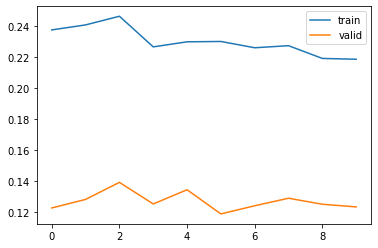

In [35]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['valid_loss'], label='valid')
plt.legend()